# Advanced Computational Methods Project 2
## Vikalp Thukral, 406534669
### Problem 1

--- American Put Option Price Convergence Analysis ---
Date of Analysis: 2025-05-17
Initial Asset Price (S0): $180.00
Strike Price (K): $180.00
Time to Maturity (T): 0.5 years
Risk-Free Rate (r): 5.50%
Volatility (sigma): 25.00%

Calculating option prices for different numbers of time steps (n):
------------------------------------------------------------
N Steps    | CRR Price ($)        | JR Price ($)        
------------------------------------------------------------
20         | 10.6223              | 10.6761             
40         | 10.6530              | 10.7015             
80         | 10.6674              | 10.7043             
100        | 10.6702              | 10.7030             
200        | 10.6761              | 10.6960             
500        | 10.6795              | 10.6856             
------------------------------------------------------------


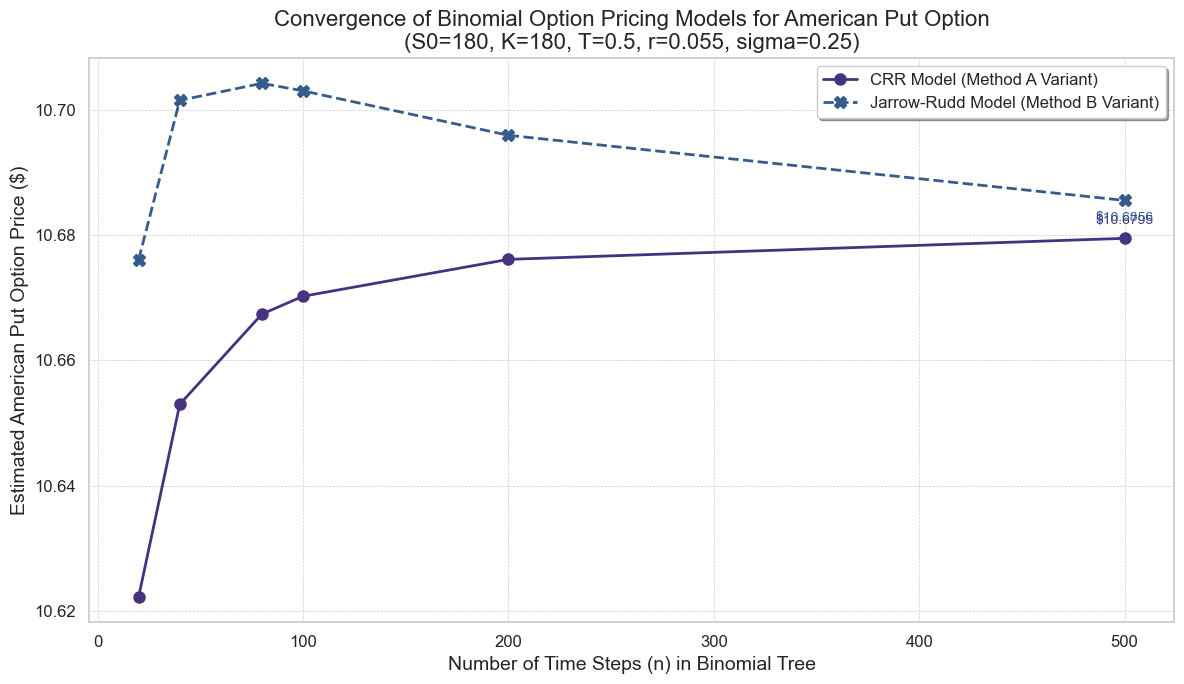

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

CURRENT_DATE_STR = "2025-05-17"

def configure_plot_aesthetics():
    """
    Sets global plotting aesthetics for a professional and consistent look.
    Utilizes seaborn for enhanced visual appeal.
    """
    sns.set_theme(style="whitegrid", palette="viridis")
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'figure.titlesize': 18
    })

class OptionPricingError(Exception):
    """Custom exception for errors during option pricing calculation."""
    pass

INITIAL_ASSET_PRICE = 180.00
STRIKE_PRICE = 180.00
TIME_TO_MATURITY_YEARS = 0.5
RISK_FREE_INTEREST_RATE = 0.055
VOLATILITY = 0.25

NUMBER_OF_STEPS_SEQUENCE = [20, 40, 80, 100, 200, 500]

def calculate_american_put_cox_ross_rubinstein(
    initial_asset_price: float,
    strike_price: float,
    time_to_maturity: float,
    risk_free_rate: float,
    asset_volatility: float,
    num_time_steps: int
) -> float:
    """
    Calculates the price of an American put option using the Cox-Ross-Rubinstein (CRR)
    binomial tree model.

    The CRR model defines the up and down factors based on volatility and
    a risk-neutral probability.

    Parameters
    ----------
    initial_asset_price : float
        The current market price of the underlying asset (S0).
    strike_price : float
        The price at which the option holder can sell the asset (K).
    time_to_maturity : float
        The lifespan of the option, expressed in years (T).
    risk_free_rate : float
        The annualized continuously compounded risk-free interest rate (r).
    asset_volatility : float
        The annualized volatility of the underlying asset's returns (sigma).
    num_time_steps : int
        The number of discrete time steps in the binomial tree (n).

    Returns
    -------
    float
        The estimated price of the American put option.

    Raises
    ------
    OptionPricingError
        If `num_time_steps` is not a positive integer or other calculation errors occur.
    ValueError
        If inputs lead to invalid mathematical operations (e.g., negative sqrt).
    """
    if not isinstance(num_time_steps, int) or num_time_steps <= 0:
        raise OptionPricingError("Number of time steps (num_time_steps) must be a positive integer.")

    try:
        delta_t = time_to_maturity / num_time_steps

        c_factor = 0.5 * (np.exp(-risk_free_rate * delta_t) +
                           np.exp((risk_free_rate + asset_volatility**2) * delta_t))
        
        sqrt_term = c_factor**2 - 1
        if sqrt_term < 0:
            raise ValueError(
                "Invalid parameters leading to a negative value under square root "
                "for 'd_factor' calculation. Check parameters like delta_t and volatility."
            )
            
        down_factor = c_factor - np.sqrt(sqrt_term)
        
        if down_factor == 0:
            raise ValueError("Down factor (d_factor) is zero, leading to division by zero for up_factor.")
            
        up_factor = 1.0 / down_factor
        
        prob_up = (np.exp(risk_free_rate * delta_t) - down_factor) / (up_factor - down_factor)
        prob_down = 1.0 - prob_up

        if not (0 <= prob_up <= 1):
            raise ValueError(
                f"Risk-neutral probability 'prob_up' ({prob_up:.4f}) is outside the valid range [0, 1]."
            )

        asset_price_lattice = np.zeros((num_time_steps + 1, num_time_steps + 1))
        option_value_lattice = np.zeros((num_time_steps + 1, num_time_steps + 1))

        for i_time_step in range(num_time_steps + 1):
            for j_state_node in range(i_time_step + 1):
                asset_price_lattice[j_state_node, i_time_step] = initial_asset_price * \
                    (up_factor**(i_time_step - j_state_node)) * (down_factor**j_state_node)

        option_value_lattice[:, num_time_steps] = np.maximum(
            strike_price - asset_price_lattice[:, num_time_steps], 0
        )

        for i_time_step in range(num_time_steps - 1, -1, -1):
            for j_state_node in range(i_time_step + 1):
                value_if_held = np.exp(-risk_free_rate * delta_t) * \
                    (prob_up * option_value_lattice[j_state_node, i_time_step + 1] +
                     prob_down * option_value_lattice[j_state_node + 1, i_time_step + 1])
                value_if_exercised = strike_price - asset_price_lattice[j_state_node, i_time_step]
                option_value_lattice[j_state_node, i_time_step] = max(value_if_exercised, value_if_held)
        
        return option_value_lattice[0, 0]

    except FloatingPointError as e:
        raise OptionPricingError(f"A floating point error occurred during CRR calculation: {e}")
    except ValueError as e:
        raise OptionPricingError(f"A value error occurred: {e}")


def calculate_american_put_jarrow_rudd(
    initial_asset_price: float,
    strike_price: float,
    time_to_maturity: float,
    risk_free_rate: float,
    asset_volatility: float,
    num_time_steps: int
) -> float:
    """
    Calculates the price of an American put option using the Jarrow-Rudd (JR)
    binomial tree model, also known as the equal-probability model.

    The JR model defines up and down movements such that the risk-neutral
    probability of an up move is 0.5.

    Parameters
    ----------
    initial_asset_price : float
        The current market price of the underlying asset (S0).
    strike_price : float
        The price at which the option holder can sell the asset (K).
    time_to_maturity : float
        The lifespan of the option, expressed in years (T).
    risk_free_rate : float
        The annualized continuously compounded risk-free interest rate (r).
    asset_volatility : float
        The annualized volatility of the underlying asset's returns (sigma).
    num_time_steps : int
        The number of discrete time steps in the binomial tree (n).

    Returns
    -------
    float
        The estimated price of the American put option.

    Raises
    ------
    OptionPricingError
        If `num_time_steps` is not a positive integer or other calculation errors occur.
    ValueError
        If inputs lead to invalid mathematical operations.
    """
    if not isinstance(num_time_steps, int) or num_time_steps <= 0:
        raise OptionPricingError("Number of time steps (num_time_steps) must be a positive integer.")

    try:
        delta_t = time_to_maturity / num_time_steps

        up_factor = np.exp(
            (risk_free_rate - 0.5 * asset_volatility**2) * delta_t +
            asset_volatility * np.sqrt(delta_t)
        )
        down_factor = np.exp(
            (risk_free_rate - 0.5 * asset_volatility**2) * delta_t -
            asset_volatility * np.sqrt(delta_t)
        )
        prob_up = 0.5
        prob_down = 0.5

        asset_price_lattice = np.zeros((num_time_steps + 1, num_time_steps + 1))
        option_value_lattice = np.zeros((num_time_steps + 1, num_time_steps + 1))

        for i_time_step in range(num_time_steps + 1):
            for j_state_node in range(i_time_step + 1):
                asset_price_lattice[j_state_node, i_time_step] = initial_asset_price * \
                    (up_factor**(i_time_step - j_state_node)) * (down_factor**j_state_node)

        option_value_lattice[:, num_time_steps] = np.maximum(
            strike_price - asset_price_lattice[:, num_time_steps], 0
        )

        for i_time_step in range(num_time_steps - 1, -1, -1):
            for j_state_node in range(i_time_step + 1):
                value_if_held = np.exp(-risk_free_rate * delta_t) * \
                    (prob_up * option_value_lattice[j_state_node, i_time_step + 1] +
                     prob_down * option_value_lattice[j_state_node + 1, i_time_step + 1])
                value_if_exercised = strike_price - asset_price_lattice[j_state_node, i_time_step]
                option_value_lattice[j_state_node, i_time_step] = max(value_if_exercised, value_if_held)
        
        return option_value_lattice[0, 0]

    except FloatingPointError as e:
        raise OptionPricingError(f"A floating point error occurred during JR calculation: {e}")
    except ValueError as e:
        raise OptionPricingError(f"A value error occurred: {e}")


def run_convergence_analysis_and_plot():
    """
    Performs a convergence analysis for American put option pricing using two
    binomial methods (CRR and JR) for a range of time steps.
    Results are then plotted to visualize convergence.
    """
    configure_plot_aesthetics()

    option_prices_crr = []
    option_prices_jr = []

    print("--- American Put Option Price Convergence Analysis ---")
    print(f"Date of Analysis: {CURRENT_DATE_STR}")
    print(f"Initial Asset Price (S0): ${INITIAL_ASSET_PRICE:.2f}")
    print(f"Strike Price (K): ${STRIKE_PRICE:.2f}")
    print(f"Time to Maturity (T): {TIME_TO_MATURITY_YEARS} years")
    print(f"Risk-Free Rate (r): {RISK_FREE_INTEREST_RATE*100:.2f}%")
    print(f"Volatility (sigma): {VOLATILITY*100:.2f}%\n")
    print("Calculating option prices for different numbers of time steps (n):")
    print("-" * 60)
    print(f"{'N Steps':<10} | {'CRR Price ($)':<20} | {'JR Price ($)':<20}")
    print("-" * 60)

    price_crr_val = np.nan
    price_jr_val = np.nan

    for num_steps in NUMBER_OF_STEPS_SEQUENCE:
        try:
            price_crr_val = calculate_american_put_cox_ross_rubinstein(
                INITIAL_ASSET_PRICE, STRIKE_PRICE, TIME_TO_MATURITY_YEARS,
                RISK_FREE_INTEREST_RATE, VOLATILITY, num_steps
            )
            option_prices_crr.append(price_crr_val)
        except OptionPricingError as e:
            print(f"Error (CRR, N={num_steps}): {e}")
            option_prices_crr.append(np.nan)
            price_crr_val = np.nan


        try:
            price_jr_val = calculate_american_put_jarrow_rudd(
                INITIAL_ASSET_PRICE, STRIKE_PRICE, TIME_TO_MATURITY_YEARS,
                RISK_FREE_INTEREST_RATE, VOLATILITY, num_steps
            )
            option_prices_jr.append(price_jr_val)
        except OptionPricingError as e:
            print(f"Error (JR, N={num_steps}): {e}")
            option_prices_jr.append(np.nan)
            price_jr_val = np.nan
        
        if not (np.isnan(price_crr_val) or np.isnan(price_jr_val)):
             print(f"{num_steps:<10} | {price_crr_val:<20.4f} | {price_jr_val:<20.4f}")
        elif not np.isnan(price_crr_val):
             print(f"{num_steps:<10} | {price_crr_val:<20.4f} | {'Calculation Error':<20}")
        elif not np.isnan(price_jr_val):
             print(f"{num_steps:<10} | {'Calculation Error':<20} | {price_jr_val:<20.4f}")
        else:
             print(f"{num_steps:<10} | {'Calculation Error':<20} | {'Calculation Error':<20}")


    print("-" * 60)

    plt.figure(figsize=(12, 7))
    
    plt.plot(
        NUMBER_OF_STEPS_SEQUENCE, option_prices_crr,
        marker='o', linestyle='-', linewidth=2, markersize=8,
        label='CRR Model (Method A Variant)'
    )
    plt.plot(
        NUMBER_OF_STEPS_SEQUENCE, option_prices_jr,
        marker='X', linestyle='--', linewidth=2, markersize=8,
        label='Jarrow-Rudd Model (Method B Variant)'
    )

    plt.xlabel("Number of Time Steps (n) in Binomial Tree")
    plt.ylabel("Estimated American Put Option Price ($)")
    plt.title(
        "Convergence of Binomial Option Pricing Models for American Put Option\n"
        f"(S0={INITIAL_ASSET_PRICE:.0f}, K={STRIKE_PRICE:.0f}, T={TIME_TO_MATURITY_YEARS}, "
        f"r={RISK_FREE_INTEREST_RATE:.3f}, sigma={VOLATILITY:.2f})"
    )
    plt.legend(loc='best', frameon=True, shadow=True)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    if option_prices_crr and not np.isnan(option_prices_crr[-1]):
        plt.annotate(f"${option_prices_crr[-1]:.4f}", 
                     (NUMBER_OF_STEPS_SEQUENCE[-1], option_prices_crr[-1]),
                     textcoords="offset points", xytext=(0,10), ha='center',
                     fontsize=10, color=sns.color_palette("viridis")[0])
    if option_prices_jr and not np.isnan(option_prices_jr[-1]):
        plt.annotate(f"${option_prices_jr[-1]:.4f}",
                     (NUMBER_OF_STEPS_SEQUENCE[-1], option_prices_jr[-1]),
                     textcoords="offset points", xytext=(0,-15), ha='center',
                     fontsize=10, color=sns.color_palette("viridis")[1])

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    run_convergence_analysis_and_plot()

### Question 2

--- American Put Option Delta Sensitivity Analysis ---
Analysis Date: 2025-05-17
Strike Price (K): $180.00
Risk-Free Rate (r): 5.50%
Volatility (sigma): 25.00%
Time to Maturity (T): 0.5 years
Number of Time Steps for Binomial Tree (n): 100

Calculating Delta for various initial asset prices (S0):
--------------------------------------------------
S0 ($)          | Delta          
--------------------------------------------------
170.00          | -0.5747        
172.00          | -0.5443        
174.00          | -0.5151        
176.00          | -0.4855        
178.00          | -0.4572        
180.00          | -0.4300        
182.00          | -0.4032        
184.00          | -0.3776        
186.00          | -0.3529        
188.00          | -0.3293        
190.00          | -0.3068        
--------------------------------------------------


C:\Users\vikal\AppData\Local\Temp\ipykernel_31224\2274194656.py:217: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


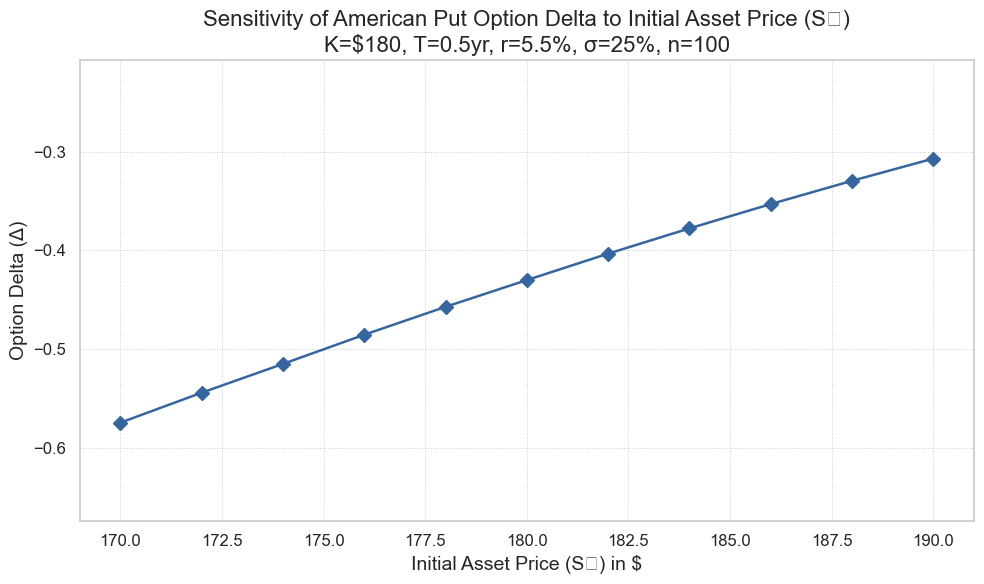

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

CURRENT_DATE_STR = "2025-05-17"

def configure_plot_aesthetics():
    """
    Sets global plotting aesthetics for a professional and consistent look.
    Utilizes seaborn for enhanced visual appeal.
    """
    sns.set_theme(style="whitegrid", palette="mako")
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'figure.titlesize': 18,
        'lines.markersize': 7,
        'lines.linewidth': 1.8
    })

class OptionPricingError(Exception):
    """Custom exception for errors during option pricing or related calculations."""
    pass

STRIKE_PRICE = 180.00
RISK_FREE_INTEREST_RATE = 0.055
VOLATILITY = 0.25
TIME_TO_MATURITY_YEARS = 0.5
NUM_TIME_STEPS_FOR_DELTA = 100

ASSET_PRICE_RANGE_FOR_DELTA = np.arange(170.0, 192.0, 2.0)


def calculate_american_put_node_values_crr(
    initial_asset_price: float,
    strike_price: float,
    time_to_maturity: float,
    risk_free_rate: float,
    asset_volatility: float,
    num_time_steps: int
) -> tuple[float, float, float, float, float]:
    """
    Calculates the American put option price at t=0 and key node values at t=1
    using the Cox-Ross-Rubinstein (CRR) binomial tree model.

    This version of CRR uses u = exp(sigma*sqrt(dt)) and d = 1/u.
    It returns values necessary for calculating option Greeks like Delta.

    Parameters
    ----------
    initial_asset_price : float
        The current market price of the underlying asset (S0).
    strike_price : float
        The price at which the option holder can sell the asset (K).
    time_to_maturity : float
        The lifespan of the option, expressed in years (T).
    risk_free_rate : float
        The annualized continuously compounded risk-free interest rate (r).
    asset_volatility : float
        The annualized volatility of the underlying asset's returns (sigma).
    num_time_steps : int
        The number of discrete time steps in the binomial tree (n).
        Must be at least 1 for Delta calculation.

    Returns
    -------
    tuple[float, float, float, float, float]
        A tuple containing:
        - option_price_t0: Estimated option price at time 0.
        - option_value_node_up_t1: Option value at t=1 after an up move.
        - option_value_node_down_t1: Option value at t=1 after a down move.
        - asset_price_node_up_t1: Asset price at t=1 after an up move.
        - asset_price_node_down_t1: Asset price at t=1 after a down move.

    Raises
    ------
    OptionPricingError
        If `num_time_steps` is less than 1 or if other calculation errors occur
        (e.g., invalid risk-neutral probability).
    """
    if not isinstance(num_time_steps, int) or num_time_steps < 1:
        raise OptionPricingError("Number of time steps (num_time_steps) must be at least 1 for Delta calculation.")

    try:
        delta_t = time_to_maturity / num_time_steps

        up_factor = np.exp(asset_volatility * np.sqrt(delta_t))
        if up_factor == 1.0: # Avoids division by zero if sigma or dt is zero
             raise ValueError("Up factor is 1.0, leading to u-d = 0. Check volatility and time step.")
        down_factor = 1.0 / up_factor
        
        risk_neutral_prob_up = (np.exp(risk_free_rate * delta_t) - down_factor) / (up_factor - down_factor)
        risk_neutral_prob_down = 1.0 - risk_neutral_prob_up

        if not (0 <= risk_neutral_prob_up <= 1):
            raise ValueError(
                f"Risk-neutral probability 'prob_up' ({risk_neutral_prob_up:.4f}) is outside the valid range [0, 1]."
            )

        asset_price_lattice = np.zeros((num_time_steps + 1, num_time_steps + 1))
        option_value_lattice = np.zeros((num_time_steps + 1, num_time_steps + 1))

        for i_time in range(num_time_steps + 1):
            for j_nodes in range(i_time + 1):
                asset_price_lattice[j_nodes, i_time] = initial_asset_price * \
                    (up_factor**(i_time - j_nodes)) * (down_factor**j_nodes)

        option_value_lattice[:, num_time_steps] = np.maximum(
            strike_price - asset_price_lattice[:, num_time_steps], 0.0
        )

        for i_time in range(num_time_steps - 1, -1, -1):
            for j_nodes in range(i_time + 1):
                value_if_held = np.exp(-risk_free_rate * delta_t) * \
                    (risk_neutral_prob_up * option_value_lattice[j_nodes, i_time + 1] +
                     risk_neutral_prob_down * option_value_lattice[j_nodes + 1, i_time + 1])
                value_if_exercised = strike_price - asset_price_lattice[j_nodes, i_time]
                option_value_lattice[j_nodes, i_time] = np.maximum(value_if_exercised, value_if_held)
        
        option_price_t0 = option_value_lattice[0, 0]
        
        if num_time_steps >= 1:
            option_value_node_up_t1 = option_value_lattice[0, 1]
            option_value_node_down_t1 = option_value_lattice[1, 1]
            asset_price_node_up_t1 = asset_price_lattice[0, 1]
            asset_price_node_down_t1 = asset_price_lattice[1, 1]
        else: # Should not happen due to initial check, but as a fallback
            option_value_node_up_t1 = np.nan
            option_value_node_down_t1 = np.nan
            asset_price_node_up_t1 = np.nan
            asset_price_node_down_t1 = np.nan

        return (
            option_price_t0,
            option_value_node_up_t1,
            option_value_node_down_t1,
            asset_price_node_up_t1,
            asset_price_node_down_t1
        )

    except FloatingPointError as e:
        raise OptionPricingError(f"A floating point error occurred during CRR node value calculation: {e}")
    except ValueError as e:
        raise OptionPricingError(f"A value error occurred during CRR node value calculation: {e}")


def perform_delta_sensitivity_analysis():
    """
    Calculates and plots the Delta of an American put option for a range of
    initial asset prices (S0).
    """
    configure_plot_aesthetics()
    calculated_deltas = []

    print("--- American Put Option Delta Sensitivity Analysis ---")
    print(f"Analysis Date: {CURRENT_DATE_STR}")
    print(f"Strike Price (K): ${STRIKE_PRICE:.2f}")
    print(f"Risk-Free Rate (r): {RISK_FREE_INTEREST_RATE*100:.2f}%")
    print(f"Volatility (sigma): {VOLATILITY*100:.2f}%")
    print(f"Time to Maturity (T): {TIME_TO_MATURITY_YEARS} years")
    print(f"Number of Time Steps for Binomial Tree (n): {NUM_TIME_STEPS_FOR_DELTA}\n")
    print("Calculating Delta for various initial asset prices (S0):")
    print("-" * 50)
    print(f"{'S0 ($)':<15} | {'Delta':<15}")
    print("-" * 50)

    for current_asset_price in ASSET_PRICE_RANGE_FOR_DELTA:
        try:
            _, opt_val_up, opt_val_down, asset_price_up, asset_price_down = \
                calculate_american_put_node_values_crr(
                    current_asset_price, STRIKE_PRICE, TIME_TO_MATURITY_YEARS,
                    RISK_FREE_INTEREST_RATE, VOLATILITY, NUM_TIME_STEPS_FOR_DELTA
                )
            
            if (asset_price_up - asset_price_down) == 0:
                delta_value = np.nan # Avoid division by zero
                print(f"{current_asset_price:<15.2f} | {'Undefined (Su=Sd)':<15}")
            else:
                delta_value = (opt_val_up - opt_val_down) / (asset_price_up - asset_price_down)
                print(f"{current_asset_price:<15.2f} | {delta_value:<15.4f}")
            calculated_deltas.append(delta_value)

        except OptionPricingError as e:
            print(f"Error calculating Delta for S0=${current_asset_price:.2f}: {e}")
            calculated_deltas.append(np.nan)
    print("-" * 50)

    plt.figure(figsize=(10, 6))
    plt.plot(
        ASSET_PRICE_RANGE_FOR_DELTA,
        calculated_deltas,
        marker='D',
        linestyle='-',
        color=sns.color_palette("mako")[2]
    )
    
    title_str = (
        f"Sensitivity of American Put Option Delta to Initial Asset Price (S₀)\n"
        f"K=${STRIKE_PRICE:.0f}, T={TIME_TO_MATURITY_YEARS}yr, r={RISK_FREE_INTEREST_RATE*100:.1f}%, "
        f"σ={VOLATILITY*100:.0f}%, n={NUM_TIME_STEPS_FOR_DELTA}"
    )
    plt.title(title_str)
    plt.xlabel("Initial Asset Price (S₀) in $")
    plt.ylabel("Option Delta (Δ)")
    plt.grid(True, which="both", linestyle=":", linewidth=0.7)
    
    plt.axhline(0, color='black', lw=0.75, linestyle='--')
    plt.axhline(-1, color='black', lw=0.75, linestyle='--')
    plt.ylim(min(calculated_deltas)-0.1 if calculated_deltas and not all(np.isnan(d) for d in calculated_deltas) else -1.1, 
             max(calculated_deltas)+0.1 if calculated_deltas and not all(np.isnan(d) for d in calculated_deltas) else 0.1)


    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    perform_delta_sensitivity_analysis()

--- American Put Option Delta vs. Time to Maturity Analysis ---
Analysis Datetime: 2025-05-17 14:35:02
Fixed Initial Asset Price (S0): $180.00
Strike Price (K): $180.00
Risk-Free Rate (r): 5.50%
Volatility (sigma): 25.00%
Number of Time Steps for Binomial Tree (n): 100

Calculating Delta for various times to maturity (T):
------------------------------------------------------------
Time to Maturity (T)      | Delta          
------------------------------------------------------------
0.0030                    | -0.4935        
0.0060                    | -0.4909        
0.0090                    | -0.4890        
0.0120                    | -0.4874        
0.0150                    | -0.4859        
0.0180                    | -0.4846        
0.0210                    | -0.4835        
0.0240                    | -0.4824        
0.0270                    | -0.4814        
0.0300                    | -0.4804        
0.0330                    | -0.4795        
0.0360                    

Font 'default' does not have a glyph for '\u2080' [U+2080], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2080' [U+2080], substituting with a dummy symbol.


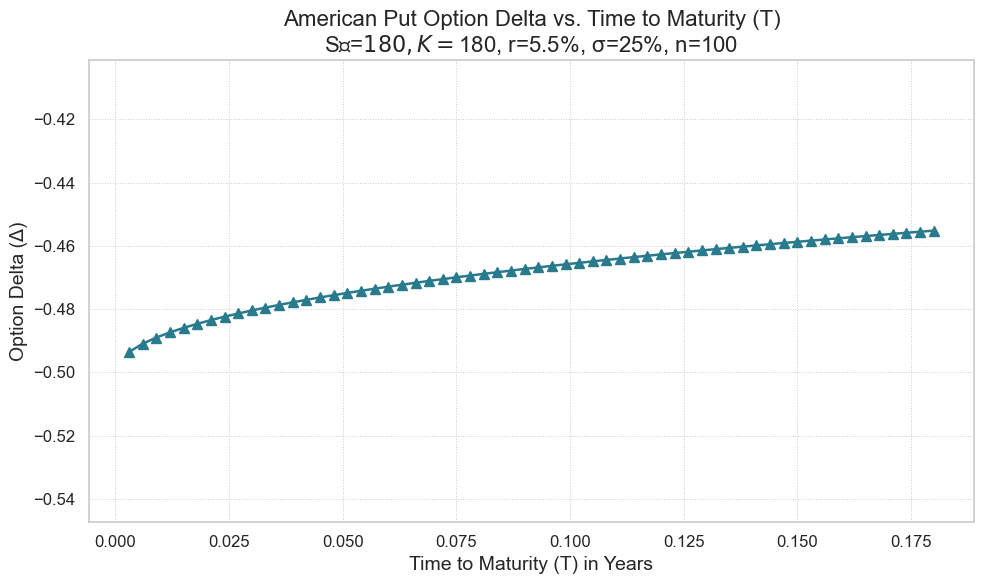

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

CURRENT_DATETIME_STR = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

def configure_plot_aesthetics():
    """
    Sets global plotting aesthetics for a professional and consistent look.
    Utilizes seaborn for enhanced visual appeal.
    """
    sns.set_theme(style="whitegrid", palette="crest_r")
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'figure.titlesize': 18,
        'lines.markersize': 7,
        'lines.linewidth': 1.8
    })

class OptionPricingError(Exception):
    """Custom exception for errors during option pricing or related calculations."""
    pass

STRIKE_PRICE = 180.00
RISK_FREE_INTEREST_RATE = 0.055
VOLATILITY = 0.25
FIXED_INITIAL_ASSET_PRICE = 180.00
FIXED_NUM_TIME_STEPS = 100

TIME_TO_MATURITY_ANALYSIS_RANGE = np.arange(0.003, 0.183, 0.003)


def perform_delta_vs_time_to_maturity_analysis():
    """
    Calculates and plots the Delta of an American put option for a range of
    times to maturity (T), keeping other parameters constant.
    """
    configure_plot_aesthetics()
    calculated_deltas_over_time = []

    print("--- American Put Option Delta vs. Time to Maturity Analysis ---")
    print(f"Analysis Datetime: {CURRENT_DATETIME_STR}")
    print(f"Fixed Initial Asset Price (S0): ${FIXED_INITIAL_ASSET_PRICE:.2f}")
    print(f"Strike Price (K): ${STRIKE_PRICE:.2f}")
    print(f"Risk-Free Rate (r): {RISK_FREE_INTEREST_RATE*100:.2f}%")
    print(f"Volatility (sigma): {VOLATILITY*100:.2f}%")
    print(f"Number of Time Steps for Binomial Tree (n): {FIXED_NUM_TIME_STEPS}\n")
    print("Calculating Delta for various times to maturity (T):")
    print("-" * 60)
    print(f"{'Time to Maturity (T)':<25} | {'Delta':<15}")
    print("-" * 60)

    for current_time_to_maturity in TIME_TO_MATURITY_ANALYSIS_RANGE:
        try:
            _, opt_val_up, opt_val_down, asset_price_up, asset_price_down = \
                calculate_american_put_node_values_crr(
                    FIXED_INITIAL_ASSET_PRICE, STRIKE_PRICE, current_time_to_maturity,
                    RISK_FREE_INTEREST_RATE, VOLATILITY, FIXED_NUM_TIME_STEPS
                )
            
            denominator = asset_price_up - asset_price_down
            if denominator == 0:
                delta_value = np.nan 
                print(f"{current_time_to_maturity:<25.4f} | {'Undefined (Su=Sd)':<15}")
            else:
                delta_value = (opt_val_up - opt_val_down) / denominator
                print(f"{current_time_to_maturity:<25.4f} | {delta_value:<15.4f}")
            calculated_deltas_over_time.append(delta_value)

        except OptionPricingError as e:
            print(f"Error for T={current_time_to_maturity:.4f}: {e}")
            calculated_deltas_over_time.append(np.nan)
    print("-" * 60)

    plt.figure(figsize=(10, 6))
    plt.plot(
        TIME_TO_MATURITY_ANALYSIS_RANGE,
        calculated_deltas_over_time,
        marker='^',
        linestyle='-',
        color=sns.color_palette("crest_r")[2]
    )
    
    title_str = (
        f"American Put Option Delta vs. Time to Maturity (T)\n"
        f"S₀=${FIXED_INITIAL_ASSET_PRICE:.0f}, K=${STRIKE_PRICE:.0f}, "
        f"r={RISK_FREE_INTEREST_RATE*100:.1f}%, σ={VOLATILITY*100:.0f}%, n={FIXED_NUM_TIME_STEPS}"
    )
    plt.title(title_str)
    plt.xlabel("Time to Maturity (T) in Years")
    plt.ylabel("Option Delta (Δ)")
    plt.grid(True, which="both", linestyle=":", linewidth=0.7)
    
    plt.axhline(0, color='black', lw=0.75, linestyle='--')
    plt.axhline(-1, color='black', lw=0.75, linestyle='--')
    
    valid_deltas = [d for d in calculated_deltas_over_time if not np.isnan(d)]
    if valid_deltas:
        min_y = min(valid_deltas)
        max_y = max(valid_deltas)
        padding = (max_y - min_y) * 0.1 if (max_y - min_y) > 0 else 0.1
        plt.ylim(min_y - padding -0.05, max_y + padding + 0.05) # Adjusted padding for better view near -1 or 0
    else: # Fallback if all are NaN
        plt.ylim(-1.1, 0.1)


    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    perform_delta_vs_time_to_maturity_analysis()

=== American Put Option Theta vs Time to Maturity ===
Run Date: 2025-05-17
S0 = $180.00, K = $180.00, r = 5.50%, sigma = 25.00%, Steps = 100
-------------------------------------------------------
T (Years)            | Theta          
-------------------------------------------------------
0.0060               | -131.08931     
0.0090               | -99.60484      
0.0120               | -83.31529      
0.0150               | -72.91071      
0.0180               | -65.51749      
0.0210               | -59.91867      
0.0240               | -55.48708      
0.0270               | -51.86401      
0.0300               | -48.83428      
0.0330               | -46.25056      
0.0360               | -44.01388      
0.0390               | -42.05231      
0.0420               | -40.31010      
0.0450               | -38.75373      
0.0480               | -37.35219      
0.0510               | -36.08131      
0.0540               | -34.91808      
0.0570               | -33.85056      
0.0600

Font 'default' does not have a glyph for '\u2080' [U+2080], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2080' [U+2080], substituting with a dummy symbol.


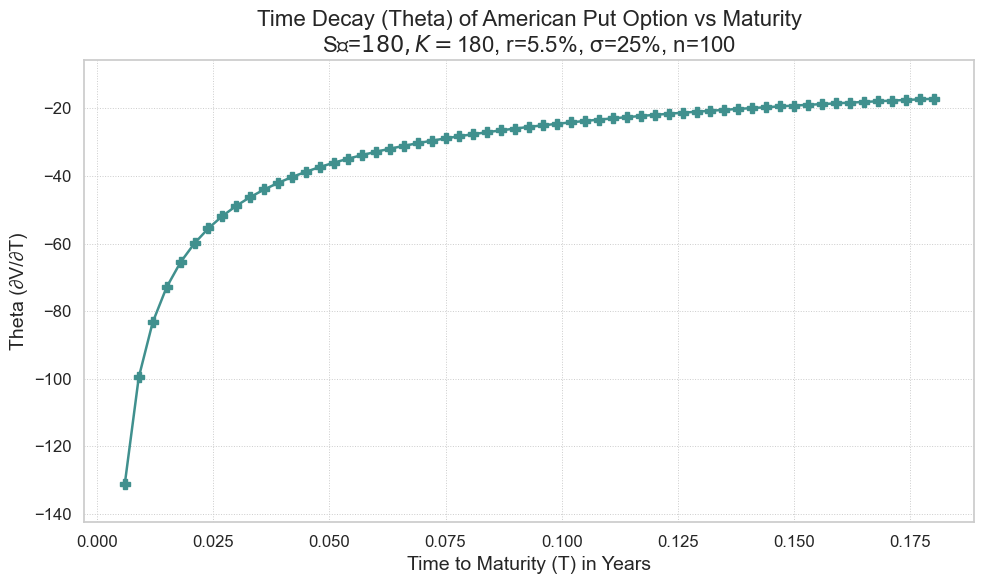

In [4]:
# ---- Theta Sensitivity Analysis ----
THETA_ANALYSIS_TIMESTAMP = CURRENT_DATE_STR
BASE_PRICE_THETA = 180.00
STEP_COUNT_THETA = 100
THETA_TIME_VALUES = np.arange(0.006, 0.183, 0.003)
TIME_SHIFT_EPSILON = 0.003

def estimate_theta_via_finite_difference(s0, k, t, r, sigma, n, shift_dt=0.003):
    """
    Estimates Theta by computing option prices at T and T - shift_dt.
    Returns the rate of time decay (Theta) using backward difference.
    """
    try:
        price_now, *_ = calculate_american_put_node_values_crr(s0, k, t, r, sigma, n)
        price_before, *_ = calculate_american_put_node_values_crr(s0, k, t - shift_dt, r, sigma, n)
        return (price_before - price_now) / shift_dt
    except OptionPricingError as err:
        return np.nan

def run_theta_vs_maturity_analysis():
    """
    Computes and plots the Theta of an American Put option
    against different times to maturity, using CRR model.
    """
    configure_plot_aesthetics()
    theta_outputs = []

    print("=== American Put Option Theta vs Time to Maturity ===")
    print(f"Run Date: {THETA_ANALYSIS_TIMESTAMP}")
    print(f"S0 = ${BASE_PRICE_THETA:.2f}, K = ${STRIKE_PRICE:.2f}, r = {RISK_FREE_INTEREST_RATE:.2%}, "
          f"sigma = {VOLATILITY:.2%}, Steps = {STEP_COUNT_THETA}")
    print("-" * 55)
    print(f"{'T (Years)':<20} | {'Theta':<15}")
    print("-" * 55)

    for ttm in THETA_TIME_VALUES:
        theta_val = estimate_theta_via_finite_difference(
            BASE_PRICE_THETA, STRIKE_PRICE, ttm,
            RISK_FREE_INTEREST_RATE, VOLATILITY,
            STEP_COUNT_THETA, TIME_SHIFT_EPSILON
        )
        theta_outputs.append(theta_val)
        theta_display = f"{theta_val:.5f}" if not np.isnan(theta_val) else "Calculation Error"
        print(f"{ttm:<20.4f} | {theta_display:<15}")

    print("-" * 55)

    plt.figure(figsize=(10, 6))
    plt.plot(
        THETA_TIME_VALUES, theta_outputs,
        marker='P', linestyle='-', color=sns.color_palette("crest_r")[3]
    )
    plt.title(
        f"Time Decay (Theta) of American Put Option vs Maturity\n"
        f"S₀=${BASE_PRICE_THETA:.0f}, K=${STRIKE_PRICE:.0f}, "
        f"r={RISK_FREE_INTEREST_RATE*100:.1f}%, σ={VOLATILITY*100:.0f}%, n={STEP_COUNT_THETA}"
    )
    plt.xlabel("Time to Maturity (T) in Years")
    plt.ylabel("Theta (∂V/∂T)")
    plt.grid(True, linestyle=":", linewidth=0.7)
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    
    finite_values = [theta for theta in theta_outputs if not np.isnan(theta)]
    if finite_values:
        min_theta = min(finite_values)
        max_theta = max(finite_values)
        pad = 0.1 * (max_theta - min_theta) if (max_theta - min_theta) > 0 else 0.05
        plt.ylim(min_theta - pad, max_theta + pad)
    else:
        plt.ylim(-1.1, 0.1)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_theta_vs_maturity_analysis()


=== American Put Vega Sensitivity to Spot Price ===
Analysis Date: 2025-05-17
Strike = $180.00, r = 5.50%, T = 0.5, σ = 25.00%, Steps = 100
Volatility shift for Vega ≈ 0.01

--------------------------------------------------
S₀ ($)          | Vega           
--------------------------------------------------
170.00          | 46.13131       
172.00          | 46.70613       
174.00          | 48.19371       
176.00          | 48.85663       
178.00          | 49.02224       
180.00          | 49.05830       
182.00          | 49.06724       
184.00          | 48.98469       
186.00          | 48.85165       
188.00          | 47.08231       
190.00          | 46.81402       
--------------------------------------------------


C:\Users\vikal\AppData\Local\Temp\ipykernel_31224\980761553.py:72: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()


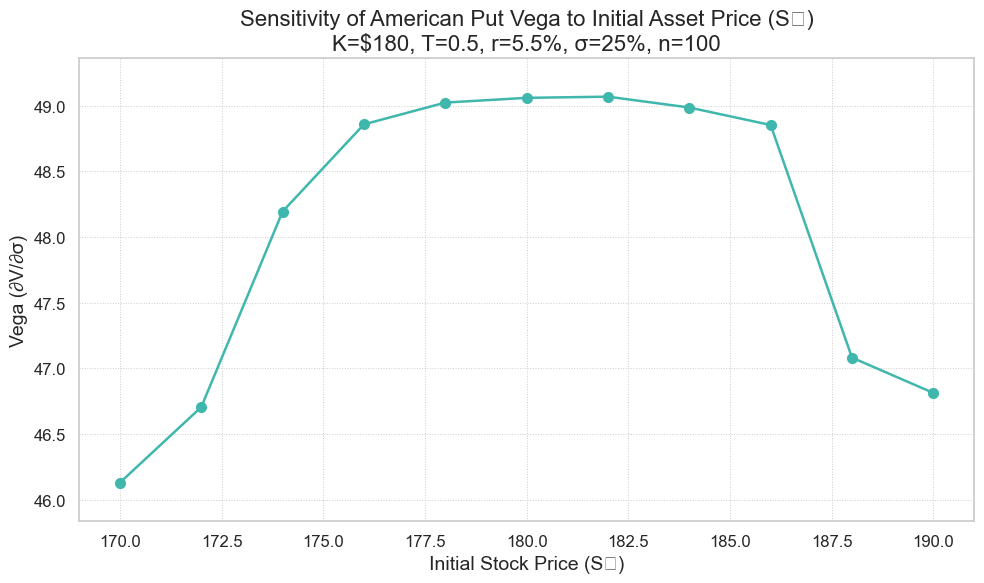

In [5]:
# ---- Vega Sensitivity Analysis ----
VEGA_ANALYSIS_DATE = CURRENT_DATE_STR
FIXED_STRIKE_VEGA = STRIKE_PRICE
FIXED_RATE_VEGA = RISK_FREE_INTEREST_RATE
FIXED_MATURITY_VEGA = TIME_TO_MATURITY_YEARS
FIXED_STEPS_VEGA = 100
VOL_SHIFT_EPSILON = 0.01
S0_SPAN_VEGA = np.arange(170, 192, 2)

def estimate_vega_crr_binomial(
    s0: float, k: float, t: float, r: float, vol: float, n: int, d_sigma: float = 0.01
) -> float:
    """
    Estimates Vega using central finite difference on volatility (σ).
    """
    try:
        price_up, *_ = calculate_american_put_node_values_crr(s0, k, t, r, vol + d_sigma, n)
        price_down, *_ = calculate_american_put_node_values_crr(s0, k, t, r, vol - d_sigma, n)
        return (price_up - price_down) / (2 * d_sigma)
    except OptionPricingError:
        return np.nan

def perform_vega_vs_spot_analysis():
    """
    Evaluates and plots Vega of an American Put with respect to varying S₀.
    """
    configure_plot_aesthetics()
    vega_values = []

    print("=== American Put Vega Sensitivity to Spot Price ===")
    print(f"Analysis Date: {VEGA_ANALYSIS_DATE}")
    print(f"Strike = ${FIXED_STRIKE_VEGA:.2f}, r = {FIXED_RATE_VEGA:.2%}, T = {FIXED_MATURITY_VEGA}, "
          f"σ = {VOLATILITY:.2%}, Steps = {FIXED_STEPS_VEGA}")
    print(f"Volatility shift for Vega ≈ {VOL_SHIFT_EPSILON}\n")
    print("-" * 50)
    print(f"{'S₀ ($)':<15} | {'Vega':<15}")
    print("-" * 50)

    for spot in S0_SPAN_VEGA:
        vega_val = estimate_vega_crr_binomial(
            s0=spot, k=FIXED_STRIKE_VEGA, t=FIXED_MATURITY_VEGA,
            r=FIXED_RATE_VEGA, vol=VOLATILITY, n=FIXED_STEPS_VEGA,
            d_sigma=VOL_SHIFT_EPSILON
        )
        vega_values.append(vega_val)
        display_val = f"{vega_val:.5f}" if not np.isnan(vega_val) else "Calc Error"
        print(f"{spot:<15.2f} | {display_val:<15}")
    print("-" * 50)

    plt.figure(figsize=(10, 6))
    plt.plot(
        S0_SPAN_VEGA, vega_values,
        marker='o', linestyle='-', color=sns.color_palette("mako")[4]
    )
    plt.title(
        f"Sensitivity of American Put Vega to Initial Asset Price (S₀)\n"
        f"K=${FIXED_STRIKE_VEGA:.0f}, T={FIXED_MATURITY_VEGA}, "
        f"r={FIXED_RATE_VEGA*100:.1f}%, σ={VOLATILITY*100:.0f}%, n={FIXED_STEPS_VEGA}"
    )
    plt.xlabel("Initial Stock Price (S₀)")
    plt.ylabel("Vega (∂V/∂σ)")
    plt.grid(True, linestyle=":", linewidth=0.7)
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

    finite_vegas = [v for v in vega_values if not np.isnan(v)]
    if finite_vegas:
        buffer = 0.1 * (max(finite_vegas) - min(finite_vegas)) if max(finite_vegas) != min(finite_vegas) else 0.05
        plt.ylim(min(finite_vegas) - buffer, max(finite_vegas) + buffer)
    else:
        plt.ylim(-1.0, 1.0)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    perform_vega_vs_spot_analysis()


### Question 3

In [6]:
def compute_trinomial_american_put(
    s0: float = 180.0,
    k: float = 180.0,
    t: float = 0.5,
    r: float = 0.055,
    sigma: float = 0.25,
    steps: int = 100
) -> float:
    """
    Computes the price of an American put option using a recombining trinomial tree.

    This implementation follows a lognormal trinomial model where the asset price can
    move up, down, or stay the same in each time step. The model accounts for early
    exercise, making it suitable for pricing American-style options.

    Parameters
    ----------
    s0 : float
        Current price of the underlying asset.
    k : float
        Strike price of the option.
    t : float
        Time to maturity in years.
    r : float
        Continuously compounded annual risk-free rate.
    sigma : float
        Annual volatility of the underlying asset.
    steps : int
        Number of time intervals in the trinomial tree.

    Returns
    -------
    float
        The estimated price of the American put option at time 0.
    """
    dt = t / steps
    df = np.exp(-r * dt)
    d = np.exp(-sigma * np.sqrt(3 * dt))
    u = 1 / d

    alpha = r * dt
    beta = sigma**2 * dt
    gamma = alpha**2

    pu = (alpha * (1 - d) + beta + gamma) / ((u - d) * (u - 1))
    pd = (alpha * (1 - u) + beta + gamma) / ((u - d) * (1 - d))
    pm = 1.0 - pu - pd

    tree = np.zeros((2 * steps + 1, steps + 1))

    for i in range(2 * steps + 1):
        m = i - steps
        s_terminal = s0 * (u ** max(m, 0)) * (d ** max(-m, 0))
        tree[i, steps] = max(k - s_terminal, 0.0)

    for j in range(steps - 1, -1, -1):
        for i in range(j + steps + 1):
            cont = df * (
                pu * tree[i - 1, j + 1] +
                pm * tree[i, j + 1] +
                pd * tree[i + 1, j + 1]
            )
            m = i - steps
            s_curr = s0 * (u ** max(m, 0)) * (d ** max(-m, 0))
            tree[i, j] = max(cont, k - s_curr)

    return tree[steps, 0]


In [7]:
def compute_trinomial_logprice_american_put(
    s0: float = 180.0,
    k: float = 180.0,
    t: float = 0.5,
    r: float = 0.055,
    sigma: float = 0.25,
    steps: int = 100
) -> float:
    """
    Computes the price of an American put option using a trinomial tree 
    constructed in the log-price domain (X = log(S)).

    This implementation is based on a recombining log-space tree with
    risk-neutral probabilities derived from the Taylor approximation
    of the SDE under the log-normal model. Early exercise is allowed.

    Parameters
    ----------
    s0 : float
        Current asset price.
    k : float
        Strike price of the option.
    t : float
        Time to expiration in years.
    r : float
        Continuously compounded risk-free interest rate.
    sigma : float
        Volatility of the underlying asset.
    steps : int
        Number of discrete steps in the trinomial tree.

    Returns
    -------
    float
        Estimated price of the American put option.
    """
    dt = t / steps
    dx = sigma * np.sqrt(3 * dt)
    disc = np.exp(-r * dt)
    mu = r - 0.5 * sigma**2

    a = sigma**2 * dt + (mu**2) * dt**2
    b = mu * dt

    pu = 0.5 * (a / dx**2 + b / dx)
    pd = 0.5 * (a / dx**2 - b / dx)
    pm = 1.0 - pu - pd

    value_matrix = np.zeros((2 * steps + 1, steps + 1))

    for i in range(2 * steps + 1):
        displacement = i - steps
        x_terminal = np.log(s0) + displacement * dx
        s_terminal = np.exp(x_terminal)
        value_matrix[i, steps] = max(k - s_terminal, 0.0)

    for j in range(steps - 1, -1, -1):
        for i in range(j + steps + 1):
            continuation = disc * (
                pu * value_matrix[i - 1, j + 1] +
                pm * value_matrix[i, j + 1] +
                pd * value_matrix[i + 1, j + 1]
            )
            x_curr = np.log(s0) + (i - steps) * dx
            s_curr = np.exp(x_curr)
            value_matrix[i, j] = max(continuation, k - s_curr)

    return value_matrix[steps, 0]


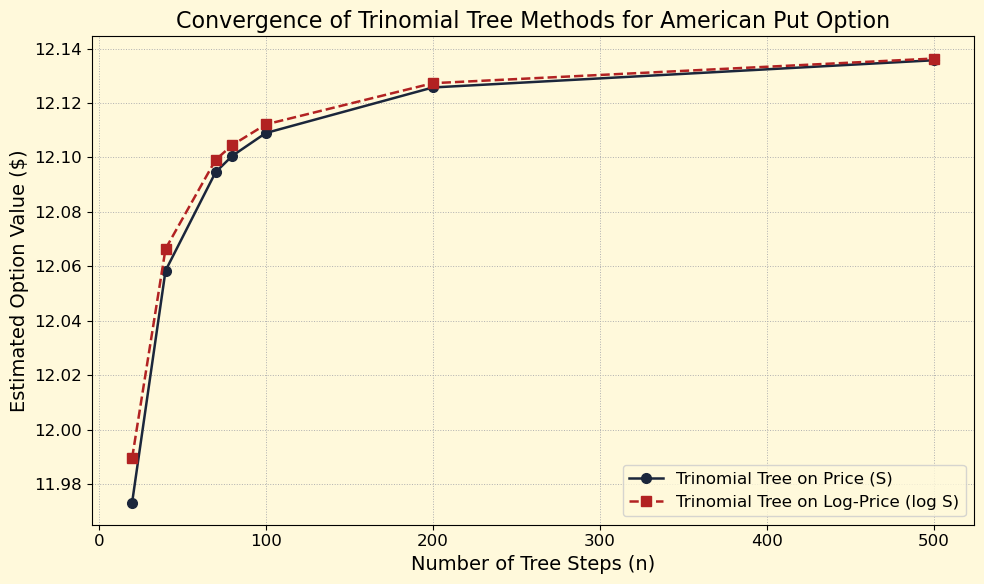

In [9]:
def plot_trinomial_model_convergence():
    """
    Evaluates and visualizes the convergence behavior of two trinomial tree approaches
    for pricing American put options: one using direct price modeling, and the other
    using log-price modeling.
    """
    plt.style.use("default")
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'figure.titlesize': 18,
        'lines.markersize': 7,
        'lines.linewidth': 1.8,
        'figure.facecolor': '#FFF9DB',
        'axes.facecolor': '#FFF9DB',
        'savefig.facecolor': '#FFF9DB'
    })

    step_sequence = [20, 40, 70, 80, 100, 200, 500]
    results_price_tree = [compute_trinomial_american_put(steps=n) for n in step_sequence]
    results_logprice_tree = [compute_trinomial_logprice_american_put(steps=n) for n in step_sequence]

    plt.figure(figsize=(10, 6))
    plt.plot(
        step_sequence, results_price_tree,
        marker='o', linestyle='-', color='#1B263B',
        label='Trinomial Tree on Price (S)'
    )
    plt.plot(
        step_sequence, results_logprice_tree,
        marker='s', linestyle='--', color='#B22222',
        label='Trinomial Tree on Log-Price (log S)'
    )

    plt.title("Convergence of Trinomial Tree Methods for American Put Option")
    plt.xlabel("Number of Tree Steps (n)")
    plt.ylabel("Estimated Option Value ($)")
    plt.grid(True, linestyle=':', linewidth=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_trinomial_model_convergence()


### Question 4

In [10]:
import numpy as np
import scipy.stats as stats
from numpy.polynomial.laguerre import lagval
from numpy.polynomial.hermite import hermval
import matplotlib.pyplot as plt
import pandas as pd

def simulate_log_paths(s0, r, sigma, t, paths, steps):
    """
    Simulates antithetic log-normal asset paths using geometric Brownian motion.
    """
    dt = t / steps
    z = np.random.randn(paths // 2, steps)
    z = np.concatenate([z, -z], axis=0)
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z
    log_paths = np.cumsum(increments, axis=1)
    final_paths = s0 * np.exp(log_paths)
    return np.concatenate([np.full((paths, 1), s0), final_paths], axis=1)

def construct_basis_matrix(s, method, degree):
    """
    Constructs basis function matrix using the chosen orthogonal polynomial type.
    """
    x = s.reshape(-1, 1)
    if method == 'laguerre':
        x_scaled = x / 100
        return np.column_stack([lagval(x_scaled.flatten(), [0]*i + [1]) for i in range(degree)])
    elif method == 'hermite':
        x_scaled = (x - np.mean(x)) / np.std(x)
        return np.column_stack([hermval(x_scaled.flatten(), [0]*i + [1]) for i in range(degree)])
    elif method == 'monomial':
        return np.column_stack([x.flatten()**i for i in range(degree)])
    else:
        raise ValueError("Invalid basis type selected.")

def price_american_put_lsmc(s0, k, r, sigma, t, num_paths, poly_degree, basis_type):
    """
    Prices an American put option using the Longstaff-Schwartz Monte Carlo method.
    """
    steps = int(np.sqrt(num_paths))
    dt = t / steps
    paths = simulate_log_paths(s0, r, sigma, t, num_paths, steps)
    cashflows = np.maximum(k - paths[:, -1], 0)

    for step in range(steps - 1, 0, -1):
        itm = (k - paths[:, step]) > 0
        if not np.any(itm):
            continue
        s_itm = paths[itm, step]
        disc_cf = cashflows[itm] * np.exp(-r * dt)
        basis = construct_basis_matrix(s_itm, basis_type, poly_degree)
        coeffs, *_ = np.linalg.lstsq(basis, disc_cf, rcond=None)
        cont_val = construct_basis_matrix(s_itm, basis_type, poly_degree) @ coeffs
        exercise_val = k - s_itm
        cashflows[itm] = np.where(exercise_val > cont_val, exercise_val, cashflows[itm] * np.exp(-r * dt))

    return np.mean(cashflows * np.exp(-r * dt))

s0 = 180
k = 180
r = 0.055
sigma = 0.25
n_sim = 100_000
degree_values = [2, 3, 4, 5]
maturities = [0.5, 1.5]
basis_families = ['laguerre', 'hermite', 'monomial']

output_table = {}

for basis in basis_families:
    output_table[basis] = {}
    for maturity in maturities:
        output_table[basis][maturity] = []
        for degree in degree_values:
            price = price_american_put_lsmc(s0, k, r, sigma, maturity, n_sim, degree, basis)
            output_table[basis][maturity].append(price)

df_output = pd.DataFrame({
    (basis.capitalize(), f"T={maturity}"): output_table[basis][maturity]
    for basis in basis_families
    for maturity in maturities
}, index=[f"k={d}" for d in degree_values])

print(df_output)


      Laguerre               Hermite              Monomial           
         T=0.5      T=1.5      T=0.5      T=1.5      T=0.5      T=1.5
k=2  10.574035  16.239865  10.529183  16.171364  10.588040  16.157523
k=3  10.679767  16.440293  10.690132  16.465174  10.663443  16.416877
k=4  10.703827  16.536469  10.719832  16.491100  10.721126  16.512954
k=5  10.706310  16.536867  10.760994  16.536630  10.732327  16.439124


### Question 5

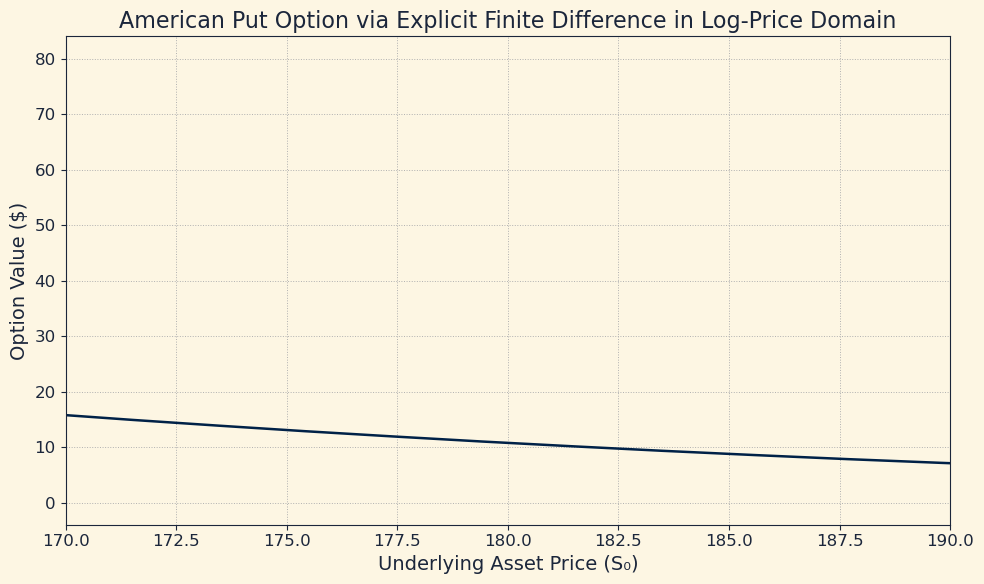

In [12]:
def configure_plot_aesthetics():
    """
    Applies a custom plot style using navy blue, crimson red, and eggshell white.
    """
    plt.style.use("default")
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'figure.titlesize': 18,
        'lines.linewidth': 1.8,
        'lines.markersize': 7,
        'axes.facecolor': '#FDF6E3',
        'figure.facecolor': '#FDF6E3',
        'savefig.facecolor': '#FDF6E3',
        'axes.edgecolor': '#1B263B',
        'axes.labelcolor': '#1B263B',
        'xtick.color': '#1B263B',
        'ytick.color': '#1B263B',
        'text.color': '#1B263B'
    })

def compute_explicit_fd_logspace_put(
    strike: float = 180.0,
    volatility: float = 0.25,
    rate: float = 0.055,
    maturity: float = 0.5,
    time_step: float = 0.002,
    space_step: float = None
):
    """
    Solves the Black-Scholes PDE for an American put option using the explicit finite
    difference method in the log-price domain.
    """
    if space_step is None:
        space_step = volatility * np.sqrt(time_step)

    x_lower = np.log(100)
    x_upper = np.log(260)
    num_x = int((x_upper - x_lower) / space_step) + 1
    num_t = int(maturity / time_step)

    x_grid = np.linspace(x_lower, x_upper, num_x)
    s_grid = np.exp(x_grid)
    payoff = np.maximum(strike - s_grid, 0)

    a = 0.5 * volatility**2 / space_step**2
    b = 0.5 * (rate - 0.5 * volatility**2) / space_step

    weight_up = time_step * (a + b)
    weight_mid = 1 - time_step * (2 * a + rate)
    weight_down = time_step * (a - b)

    option_values = payoff.copy()

    for _ in range(num_t):
        updated = option_values.copy()
        for j in range(1, num_x - 1):
            val = (
                weight_up * option_values[j + 1] +
                weight_mid * option_values[j] +
                weight_down * option_values[j - 1]
            )
            intrinsic = strike - s_grid[j]
            updated[j] = max(val, intrinsic)
        updated[0] = strike - s_grid[0]
        updated[-1] = 0.0
        option_values = updated

    return s_grid, option_values

def visualize_fd_logspace_put():
    """
    Generates and visualizes the American put price curve using the
    explicit finite difference method in log space.
    """
    configure_plot_aesthetics()
    prices, values = compute_explicit_fd_logspace_put()

    plt.figure(figsize=(10, 6))
    plt.plot(prices, values, linestyle='-', marker=None, color='#002147')
    plt.xlim(170, 190)
    plt.xlabel("Underlying Asset Price (S₀)")
    plt.ylabel("Option Value ($)")
    plt.title("American Put Option via Explicit Finite Difference in Log-Price Domain")
    plt.grid(True, linestyle=":", linewidth=0.7)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    visualize_fd_logspace_put()


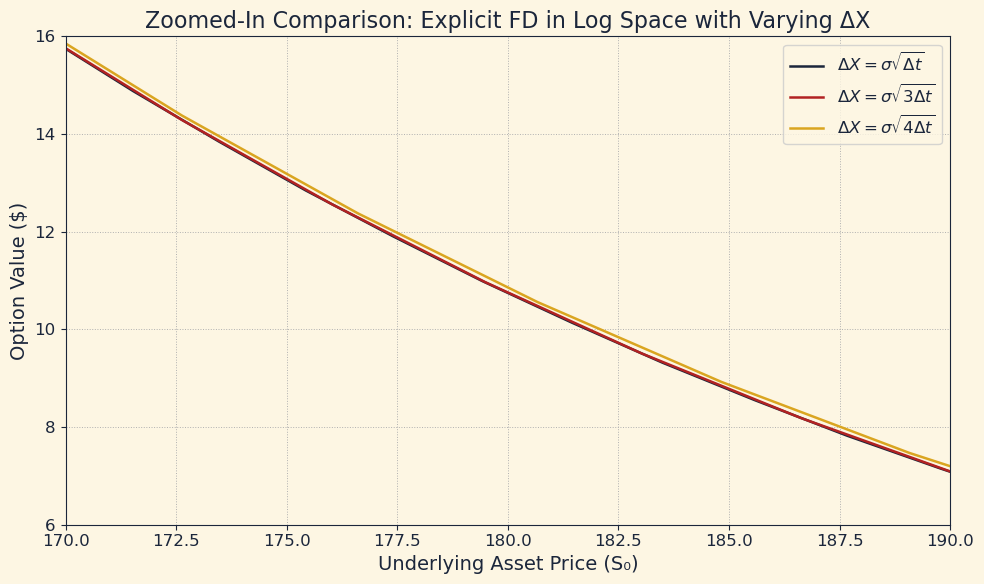

In [13]:
def plot_fd_dx_sensitivity():
    """
    Compares the effect of different space step sizes (ΔX) in the explicit
    finite difference solution for American put options in log-space.
    """
    configure_plot_aesthetics()

    vol = 0.25
    dt = 0.002

    dx_values = [
        vol * np.sqrt(dt),
        vol * np.sqrt(3 * dt),
        vol * np.sqrt(4 * dt)
    ]

    s1, v1 = compute_explicit_fd_logspace_put(volatility=vol, time_step=dt, space_step=dx_values[0])
    s2, v2 = compute_explicit_fd_logspace_put(volatility=vol, time_step=dt, space_step=dx_values[1])
    s3, v3 = compute_explicit_fd_logspace_put(volatility=vol, time_step=dt, space_step=dx_values[2])

    plt.figure(figsize=(10, 6))
    plt.plot(s1, v1, label=r"$\Delta X = \sigma \sqrt{\Delta t}$", color='#1B263B')
    plt.plot(s2, v2, label=r"$\Delta X = \sigma \sqrt{3\Delta t}$", color='#B22222')
    plt.plot(s3, v3, label=r"$\Delta X = \sigma \sqrt{4\Delta t}$", color='#DAA520')

    plt.xlim(170, 190)
    plt.ylim(6, 16)
    plt.xlabel("Underlying Asset Price (S₀)")
    plt.ylabel("Option Value ($)")
    plt.title("Zoomed-In Comparison: Explicit FD in Log Space with Varying ΔX")
    plt.grid(True, linestyle=":", linewidth=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_fd_dx_sensitivity()


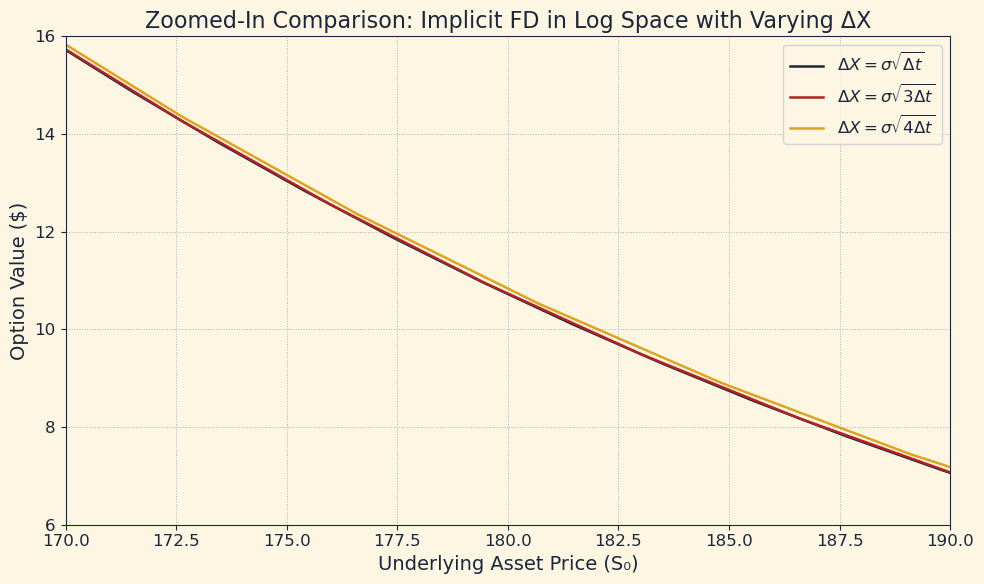

In [14]:
from scipy.linalg import solve_banded

def compute_implicit_fd_logspace_put(
    strike: float = 180.0,
    volatility: float = 0.25,
    rate: float = 0.055,
    maturity: float = 0.5,
    time_step: float = 0.002,
    space_step: float = None
):
    """
    Solves the Black-Scholes PDE for an American put using an implicit finite difference
    scheme in the log-price domain. Applies early exercise condition at each step.
    """
    if space_step is None:
        space_step = volatility * np.sqrt(time_step)

    x_lower = np.log(100)
    x_upper = np.log(260)
    num_x = int((x_upper - x_lower) / space_step) + 1
    num_t = int(maturity / time_step)

    x_grid = np.linspace(x_lower, x_upper, num_x)
    s_grid = np.exp(x_grid)

    option = np.maximum(strike - s_grid, 0.0)

    alpha = volatility**2 / (2 * space_step**2)
    beta = (rate - 0.5 * volatility**2) / (2 * space_step)
    gamma = rate

    lower = -time_step * (alpha - beta)
    center = 1 + time_step * (2 * alpha + gamma)
    upper = -time_step * (alpha + beta)

    banded_matrix = np.zeros((3, num_x - 2))
    banded_matrix[0, 1:] = upper
    banded_matrix[1, :] = center
    banded_matrix[2, :-1] = lower

    for _ in range(num_t):
        rhs = option[1:-1].copy()
        rhs[0] -= lower * (strike - s_grid[0])
        rhs[-1] -= upper * 0.0
        solution = solve_banded((1, 1), banded_matrix, rhs)
        option[1:-1] = np.maximum(solution, strike - s_grid[1:-1])
        option[0] = strike - s_grid[0]
        option[-1] = 0.0

    return s_grid, option

def plot_implicit_fd_dx_variation():
    """
    Visualizes the impact of space step size (ΔX) on American put pricing using the
    implicit finite difference scheme in log space.
    """
    configure_plot_aesthetics()
    vol = 0.25
    dt = 0.002

    dx_values = [
        vol * np.sqrt(dt),
        vol * np.sqrt(3 * dt),
        vol * np.sqrt(4 * dt)
    ]

    s1, v1 = compute_implicit_fd_logspace_put(volatility=vol, time_step=dt, space_step=dx_values[0])
    s2, v2 = compute_implicit_fd_logspace_put(volatility=vol, time_step=dt, space_step=dx_values[1])
    s3, v3 = compute_implicit_fd_logspace_put(volatility=vol, time_step=dt, space_step=dx_values[2])

    plt.figure(figsize=(10, 6))
    plt.plot(s1, v1, label=r"$\Delta X = \sigma \sqrt{\Delta t}$", color='#1B263B')
    plt.plot(s2, v2, label=r"$\Delta X = \sigma \sqrt{3\Delta t}$", color='#B22222')
    plt.plot(s3, v3, label=r"$\Delta X = \sigma \sqrt{4\Delta t}$", color='#DAA520')

    plt.xlim(170, 190)
    plt.ylim(6, 16)
    plt.xlabel("Underlying Asset Price (S₀)")
    plt.ylabel("Option Value ($)")
    plt.title("Zoomed-In Comparison: Implicit FD in Log Space with Varying ΔX")
    plt.grid(True, linestyle=":", linewidth=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_implicit_fd_dx_variation()


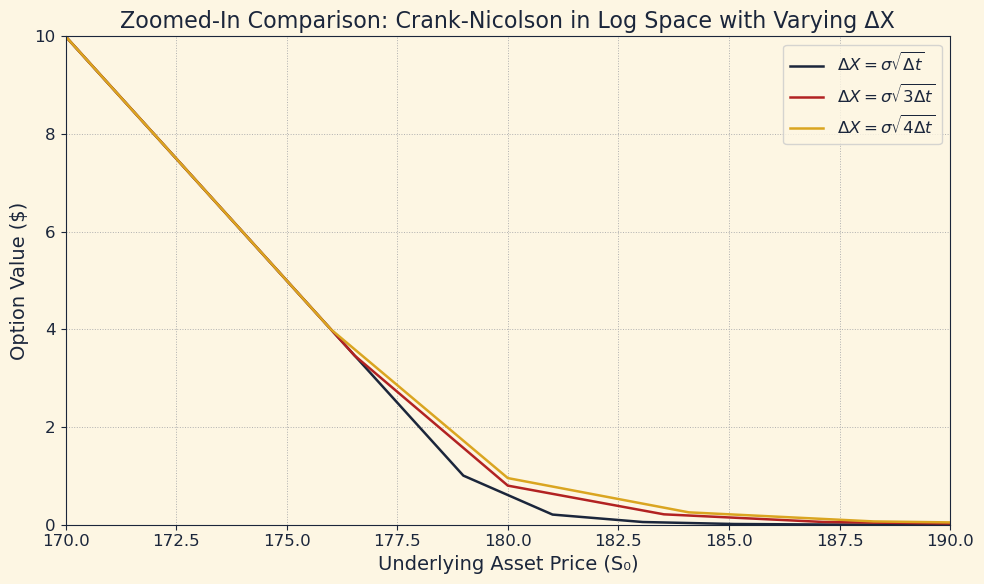

In [15]:
from scipy.linalg import solve_banded

def compute_crank_nicolson_fd_logspace_put(
    strike: float = 180.0,
    volatility: float = 0.25,
    rate: float = 0.055,
    maturity: float = 0.5,
    time_step: float = 0.002,
    space_step: float = None
):
    """
    Solves the Black-Scholes PDE for an American put option using the Crank-Nicolson
    finite difference scheme in log-price space. Applies early exercise at each step.
    """
    if space_step is None:
        space_step = volatility * np.sqrt(time_step)

    x_center = np.log(strike)
    x_span = 4.0
    x_min = x_center - x_span / 2
    x_max = x_center + x_span / 2

    num_x = int((x_max - x_min) / space_step) + 1
    num_t = int(maturity / time_step)

    x_vals = np.linspace(x_min, x_max, num_x)
    s_vals = np.exp(x_vals)

    option = np.maximum(strike - s_vals, 0.0)

    alpha = volatility**2 / (2 * space_step**2)
    beta = (rate - 0.5 * volatility**2) / (2 * space_step)
    gamma = rate

    a_A = 0.5 * time_step * (alpha - beta)
    b_A = 1 + time_step * (2 * alpha + gamma)
    c_A = 0.5 * time_step * (alpha + beta)

    banded_A = np.zeros((3, num_x - 2))
    banded_A[0, 1:] = -c_A
    banded_A[1, :] = b_A
    banded_A[2, :-1] = -a_A

    a_B = 0.5 * time_step * (alpha - beta)
    b_B = 1 - time_step * (2 * alpha + gamma)
    c_B = 0.5 * time_step * (alpha + beta)

    for _ in range(num_t):
        rhs = np.zeros(num_x - 2)
        for i in range(1, num_x - 1):
            rhs[i - 1] = (
                a_B * option[i - 1] +
                b_B * option[i] +
                c_B * option[i + 1]
            )
        rhs[0] -= a_A * (strike - s_vals[0])
        rhs[-1] += 0.0

        solution = solve_banded((1, 1), banded_A, rhs)
        option[1:-1] = np.maximum(solution, strike - s_vals[1:-1])
        option[0] = strike - s_vals[0]
        option[-1] = 0.0

    return s_vals, option

def plot_crank_nicolson_dx_variation():
    """
    Visualizes the sensitivity of the Crank-Nicolson log-space scheme for American puts
    to changes in spatial discretization (ΔX).
    """
    configure_plot_aesthetics()
    sigma = 0.25
    dt = 0.002

    dx_list = [
        sigma * np.sqrt(dt),
        sigma * np.sqrt(3 * dt),
        sigma * np.sqrt(4 * dt)
    ]

    s1, v1 = compute_crank_nicolson_fd_logspace_put(volatility=sigma, time_step=dt, space_step=dx_list[0])
    s2, v2 = compute_crank_nicolson_fd_logspace_put(volatility=sigma, time_step=dt, space_step=dx_list[1])
    s3, v3 = compute_crank_nicolson_fd_logspace_put(volatility=sigma, time_step=dt, space_step=dx_list[2])

    plt.figure(figsize=(10, 6))
    plt.plot(s1, v1, label=r"$\Delta X = \sigma \sqrt{\Delta t}$", color="#1B263B")
    plt.plot(s2, v2, label=r"$\Delta X = \sigma \sqrt{3\Delta t}$", color="#B22222")
    plt.plot(s3, v3, label=r"$\Delta X = \sigma \sqrt{4\Delta t}$", color="#DAA520")

    plt.xlim(170, 190)
    plt.ylim(0, 10)
    plt.xlabel("Underlying Asset Price (S₀)")
    plt.ylabel("Option Value ($)")
    plt.title("Zoomed-In Comparison: Crank-Nicolson in Log Space with Varying ΔX")
    plt.grid(True, linestyle=":", linewidth=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_crank_nicolson_dx_variation()


### Problem 6

<>:58: SyntaxWarning: invalid escape sequence '\D'
<>:58: SyntaxWarning: invalid escape sequence '\D'
C:\Users\vikal\AppData\Local\Temp\ipykernel_31224\4240631177.py:58: SyntaxWarning: invalid escape sequence '\D'
  plt.title("Explicit FD in S-space with Fixed $\Delta t = 0.002$ (Potential Instability)")


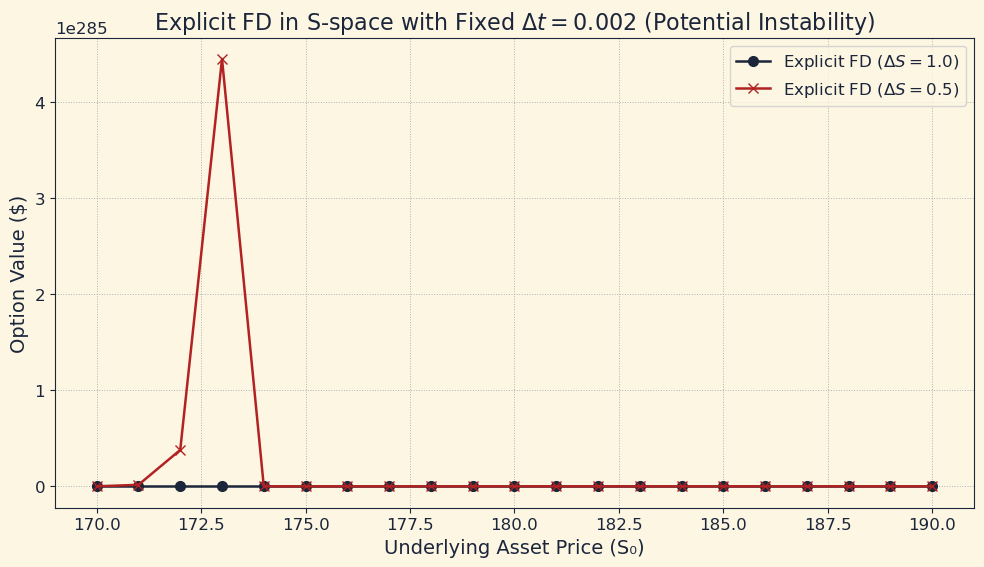

In [16]:
def compute_explicit_fd_S_space(
    strike: float = 180.0,
    volatility: float = 0.25,
    rate: float = 0.055,
    maturity: float = 0.5,
    space_step: float = 1.0,
    time_step: float = 0.002
):
    """
    Solves the Black-Scholes PDE for an American put using an explicit finite difference
    scheme in the asset price domain (S-space), applying early exercise at each step.
    """
    s_max = 2.5 * strike
    m = int(s_max / space_step)
    n = int(maturity / time_step)

    s_vals = np.linspace(0, s_max, m + 1)
    option = np.maximum(strike - s_vals, 0.0)

    for _ in range(n):
        updated = option.copy()
        for j in range(1, m):
            s = s_vals[j]
            delta = (option[j + 1] - option[j - 1]) / (2 * space_step)
            gamma = (option[j + 1] - 2 * option[j] + option[j - 1]) / (space_step ** 2)
            theta = (
                0.5 * volatility ** 2 * s ** 2 * gamma +
                rate * s * delta -
                rate * option[j]
            )
            updated[j] = option[j] - time_step * theta
            updated[j] = max(updated[j], strike - s)
        updated[0] = strike
        updated[m] = 0.0
        option = updated

    return s_vals, option

def plot_explicit_fd_s_space_instability():
    """
    Compares the results of explicit FD in S-space for different ΔS at fixed (unstable) Δt.
    """
    configure_plot_aesthetics()
    dt = 0.002

    s1, v1 = compute_explicit_fd_S_space(space_step=1.0, time_step=dt)
    s2, v2 = compute_explicit_fd_S_space(space_step=0.5, time_step=dt)

    s_eval = np.arange(170, 191)
    v1_interp = np.interp(s_eval, s1, v1)
    v2_interp = np.interp(s_eval, s2, v2)

    plt.figure(figsize=(10, 6))
    plt.plot(s_eval, v1_interp, label=r"Explicit FD ($\Delta S = 1.0$)", color="#1B263B", marker='o')
    plt.plot(s_eval, v2_interp, label=r"Explicit FD ($\Delta S = 0.5$)", color="#B22222", marker='x')
    plt.xlabel("Underlying Asset Price (S₀)")
    plt.ylabel("Option Value ($)")
    plt.title("Explicit FD in S-space with Fixed $\Delta t = 0.002$ (Potential Instability)")
    plt.grid(True, linestyle=":", linewidth=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_explicit_fd_s_space_instability()


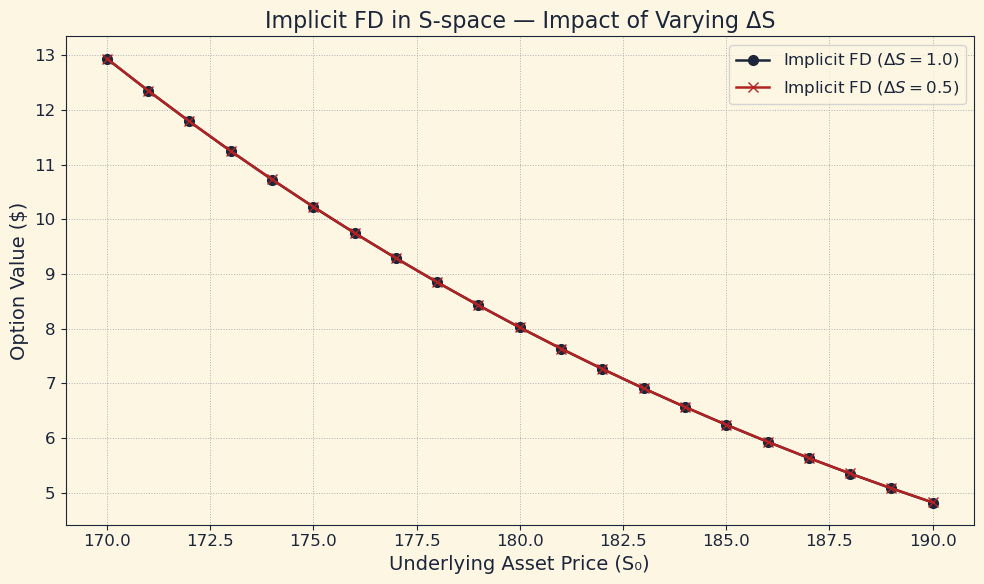

In [17]:
from scipy.linalg import solve_banded

def compute_implicit_fd_S_space(
    strike: float = 180.0,
    volatility: float = 0.25,
    rate: float = 0.055,
    maturity: float = 0.5,
    space_step: float = 1.0,
    time_step: float = 0.002
):
    """
    Solves the Black-Scholes PDE for an American put using an implicit
    finite difference scheme in asset price space (S-space).
    """
    s_max = 2.5 * strike
    m = int(s_max / space_step)
    n = int(maturity / time_step)

    s_vals = np.linspace(0, s_max, m + 1)
    option = np.maximum(strike - s_vals, 0.0)

    lower = np.zeros(m - 1)
    center = np.zeros(m - 1)
    upper = np.zeros(m - 1)

    for j in range(1, m):
        s = s_vals[j]
        a = 0.5 * volatility**2 * s**2
        b = 0.5 * rate * s

        lower[j - 1] = -time_step * (a / space_step**2 - b / space_step)
        center[j - 1] = 1 + time_step * (2 * a / space_step**2 + rate)
        upper[j - 1] = -time_step * (a / space_step**2 + b / space_step)

    banded_matrix = np.zeros((3, m - 1))
    banded_matrix[0, 1:] = upper[1:]
    banded_matrix[1, :] = center
    banded_matrix[2, :-1] = lower[:-1]

    for _ in range(n):
        rhs = option[1:m].copy()
        rhs[0] -= lower[0] * strike
        rhs[-1] -= upper[-1] * 0.0

        solution = solve_banded((1, 1), banded_matrix, rhs)
        option[1:m] = np.maximum(solution, strike - s_vals[1:m])
        option[0] = strike
        option[-1] = 0.0

    return s_vals, option

def plot_implicit_fd_s_space_comparison():
    """
    Plots American put pricing via implicit FD in S-space for two ΔS values.
    """
    configure_plot_aesthetics()
    dt = 0.002

    s1, v1 = compute_implicit_fd_S_space(space_step=1.0, time_step=dt)
    s2, v2 = compute_implicit_fd_S_space(space_step=0.5, time_step=dt)

    s_eval = np.arange(170, 191)
    v1_interp = np.interp(s_eval, s1, v1)
    v2_interp = np.interp(s_eval, s2, v2)

    plt.figure(figsize=(10, 6))
    plt.plot(s_eval, v1_interp, label=r"Implicit FD ($\Delta S = 1.0$)", color="#1B263B", marker='o')
    plt.plot(s_eval, v2_interp, label=r"Implicit FD ($\Delta S = 0.5$)", color="#B22222", marker='x')
    plt.xlabel("Underlying Asset Price (S₀)")
    plt.ylabel("Option Value ($)")
    plt.title("Implicit FD in S-space — Impact of Varying ΔS")
    plt.grid(True, linestyle=":", linewidth=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_implicit_fd_s_space_comparison()


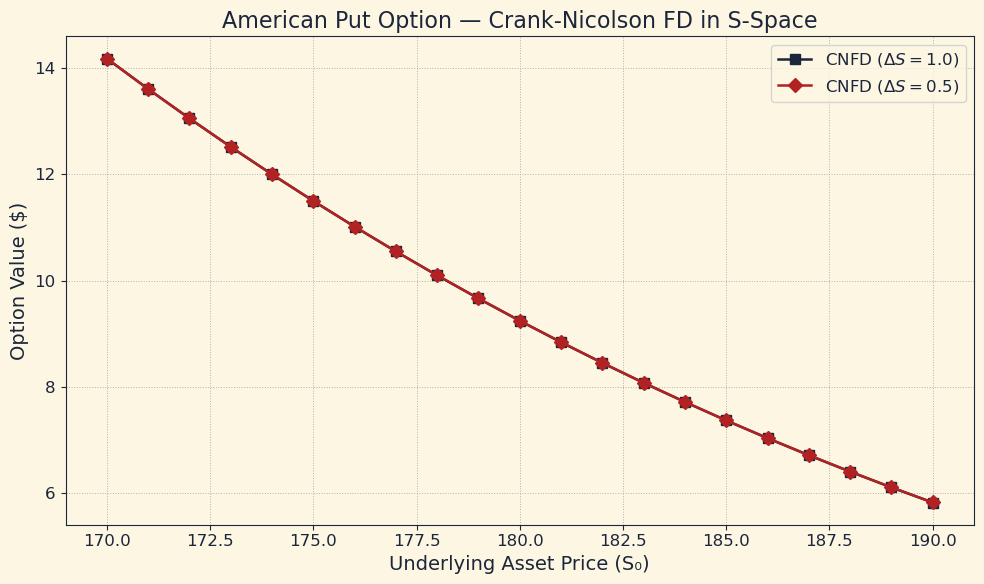

In [18]:
from scipy.linalg import solve_banded

def compute_crank_nicolson_fd_S_space(
    strike: float = 180.0,
    volatility: float = 0.25,
    rate: float = 0.055,
    maturity: float = 0.5,
    space_step: float = 1.0,
    time_step: float = 0.002
):
    """
    Prices an American put option using the Crank-Nicolson finite difference
    method in S-space (asset price grid), applying early exercise condition.
    """
    s_max = 2.5 * strike
    m = int(s_max / space_step)
    n = int(maturity / time_step)

    s_vals = np.linspace(0, s_max, m + 1)
    option = np.maximum(strike - s_vals, 0.0)

    lower_A = np.zeros(m - 1)
    center_A = np.zeros(m - 1)
    upper_A = np.zeros(m - 1)

    for j in range(1, m):
        s = s_vals[j]
        a = 0.5 * volatility**2 * s**2
        b = 0.5 * rate * s

        lower_A[j - 1] = -0.5 * time_step * (a / space_step**2 - b / space_step)
        center_A[j - 1] = 1 + 0.5 * time_step * (2 * a / space_step**2 + rate)
        upper_A[j - 1] = -0.5 * time_step * (a / space_step**2 + b / space_step)

    banded_A = np.zeros((3, m - 1))
    banded_A[0, 1:] = upper_A[1:]
    banded_A[1, :] = center_A
    banded_A[2, :-1] = lower_A[:-1]

    lower_B = -lower_A
    center_B = 2 - center_A
    upper_B = -upper_A

    for _ in range(n):
        rhs = np.zeros(m - 1)
        for j in range(1, m):
            rhs[j - 1] = (
                lower_B[j - 1] * option[j - 1] +
                center_B[j - 1] * option[j] +
                upper_B[j - 1] * option[j + 1]
            )
        rhs[0] += lower_A[0] * strike
        rhs[-1] += 0.0

        solution = solve_banded((1, 1), banded_A, rhs)
        option[1:m] = np.maximum(solution, strike - s_vals[1:m])
        option[0] = strike
        option[-1] = 0.0

    return s_vals, option

def plot_crank_nicolson_fd_s_space_comparison():
    """
    Compares CNFD results for American puts in S-space across two ΔS values.
    """
    configure_plot_aesthetics()
    dt = 0.002
    s_eval = np.arange(170, 191)

    s1, v1 = compute_crank_nicolson_fd_S_space(space_step=1.0, time_step=dt)
    s2, v2 = compute_crank_nicolson_fd_S_space(space_step=0.5, time_step=dt)

    v1_interp = np.interp(s_eval, s1, v1)
    v2_interp = np.interp(s_eval, s2, v2)

    plt.figure(figsize=(10, 6))
    plt.plot(s_eval, v1_interp, label=r"CNFD ($\Delta S = 1.0$)", color="#1B263B", marker='s')
    plt.plot(s_eval, v2_interp, label=r"CNFD ($\Delta S = 0.5$)", color="#B22222", marker='D')
    plt.xlabel("Underlying Asset Price (S₀)")
    plt.ylabel("Option Value ($)")
    plt.title("American Put Option — Crank-Nicolson FD in S-Space")
    plt.grid(True, linestyle=":", linewidth=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_crank_nicolson_fd_s_space_comparison()
